Names: Guy Cohen, Shahar Amram

IDs: 206463606, 205457898

### The objective of this assignment is to develop a predictive model using the AdaBoost algorithm to determine whether a patient has heart disease or not. We have a dataset containing various features related to patients, and based on these features, we will train an AdaBoost classifier to make accurate predictions.

In [466]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Load the csv file.
def load_data():
    data = pd.read_csv("heart_disease.csv")
    # Shuffle the data.
    shuffled_data = data.sample(frac=1).reset_index(drop=True)
    return shuffled_data

def load_data_without_2_parameters():
    data = pd.read_csv("heart_disease.csv")#cp
    data_without_ages = data.drop(["fbs","chol"], axis=1)  # Drop the 'age' column
    shuffled_data = data_without_ages.sample(frac=1).reset_index(drop=True)
    return shuffled_data

def load_data_without_6_parameters():
    data = pd.read_csv("heart_disease.csv")
    data_without_ages_and_chol = data.drop(["ca","fbs", "chol","cp","thalach","trestbps"], axis=1)  # Drop the 'age' and 'chol' columns
    shuffled_data = data_without_ages_and_chol.sample(frac=1).reset_index(drop=True)
    return shuffled_data

def load_data_without_more_parameters():
    # age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
    data = pd.read_csv("heart_disease.csv")
    data_without = data.drop(["thalach","fbs", "chol","cp","trestbps","restecg","exang","oldpeak","slope","ca"], axis=1)  # Drop the wanted columns
    shuffled_data = data_without.sample(frac=1).reset_index(drop=True)
    return shuffled_data

# Standardize the data.
def standardize(data):
    # Seperate the feateres in 'x' and 'target' in y
    x = data.drop(["target"],axis = 1)
    y = data["target"]
    # normalize
    x_mean = np.mean(x,axis=0)
    x_std = np.std(x,axis=0)
    x_std[x_std == 0] = 1e-8
    x=(x-x_mean)/x_std
    x[x > 3] = 3
    x[x < -3] = -3
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    return x, y

# plot the data.
def plot_data(data):
    X = data.drop(["target"],axis = 1)
    y = data["target"]
    # Create a DataFrame from X and y
    columns = data.columns.drop('target')
    X_df = pd.DataFrame(X, columns=columns)
    X_df['target'] = y
    # Plot the data
    plt.scatter(x=X_df.age[X_df.target == 1], y=X_df.thalach[X_df.target == 1], c="red", s=10, linewidths=1.5)
    plt.scatter(x=X_df.age[X_df.target == 0], y=X_df.thalach[X_df.target == 0], c="blue" ,s=10, linewidths=2.5)
    plt.legend(["Disease", "Not Disease"])
    plt.xlabel("Age")
    plt.ylabel("Maximum Heart Rate")
    plt.title('Heart Disease Frequency for Ages')
    plt.show()

## AdaBoost model

In [467]:
# Dicison stump with one node
class DecisionStump():
    #  Initializes the attributes of the DecisionStump object.
    def __init__(self):
        # positive or negative.
        self.polarity = 1
        # the index of the feature on which the decision stump will be based.
        self.feature_idx = None
        # the threshold value used to make the decision.
        self.threshold = None
        # Alpha is the learning rate (expert).
        self.alpha = None


# Algoorithm adaboost.
class Adaboost():
    # Initializes the attributes of the Adaboost object.
    def __init__(self, n_clf=50):
        # Number of stumps
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = X.shape
        """
        n_samples = m
        n_features = n
        """
        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = [] 

        # Iterate through classifiers
        for _ in range(self.n_clf):
            # Initialize the minimum error as infinity.
            min_error = float('inf')
            clf = DecisionStump()

            # Find the best h_t that minimizes the error, according to the weights, W_i_t.
            for feature_i in range(n_features):
                # Features vector
                X_column = X[:, feature_i]

                thresholds = np.unique(X_column,axis=None)

                for threshold in thresholds:
                    # Predict with polarity 1
                    p = 1
                    h_t = np.ones_like(y)

                    # If it smaller than threshold => -1
                    h_t[X_column <= threshold] = -1

                    # Error = sum of weights that h_t wrong.
                    error = np.sum(w[h_t != y])

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # Store the best configuration -> Store the smallest error.
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # Calculate alpha: the amount of samples that h_t got wrong
            clf.alpha = 0.5 * np.log((1 - min_error) / min_error + 1e-10)

            # Initialzie the h-t
            h_t = np.full_like(y,clf.polarity)

            # Update the h-t according to the threshold
            h_t[X[:,clf.feature_idx] <= clf.threshold] *= -1

            # Update the weight in place (t+1), the new one
            w *= np.exp(-clf.alpha * y * h_t)

            # Wi(t+1)= Wi(t+1)/(sigma(Wi(t+1))), normalizing of Wi(t+1) -> The sum of weights is 1.
            Z = np.sum(w , axis=None)
            w /= Z

            # Add each stump to the list of classifiers
            self.clfs.append(clf)
            


    # H(x) = sign(alpha_1 * h_1(x) + alpha_2 * h_2(x) + ... + alpha_t * h_t(x))
    def predict(self, X):
        # Initializes an array H of zeros with the same number of rows as the input data X.
        H = np.zeros((X.shape[0],))
        # For each stump
        for i in self.clfs:
            # Initializes an array _h_t with the same shape as H, filled with the polarity value of the current weak classifier i
            _h_t = np.full((X.shape[0],), i.polarity)
            # For each sample in x
            for j in range(X.shape[0]):
                #  If the feature value of the current data point is less than or equal to the threshold
                if X[j, i.feature_idx] <= i.threshold:
                    _h_t[j] *= -1
            # Updates the array H
            H += i.alpha * _h_t
        # Returns the sign of the array H
        return np.sign(H)

## Loading and Displaying Data

In [468]:
data = load_data()
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,56,1,2,130,256,1,0,142,1,0.6,1,1,1,0
1,60,1,0,130,206,0,0,132,1,2.4,1,2,3,0
2,62,0,0,140,268,0,0,160,0,3.6,0,2,2,0
3,46,0,0,138,243,0,0,152,1,0.0,1,0,2,1
4,50,1,2,129,196,0,1,163,0,0.0,2,0,2,1
5,55,1,1,130,262,0,1,155,0,0.0,2,0,2,1
6,57,1,0,152,274,0,1,88,1,1.2,1,1,3,0
7,49,0,0,130,269,0,1,163,0,0.0,2,0,2,1
8,54,0,1,132,288,1,0,159,1,0.0,2,1,2,1
9,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


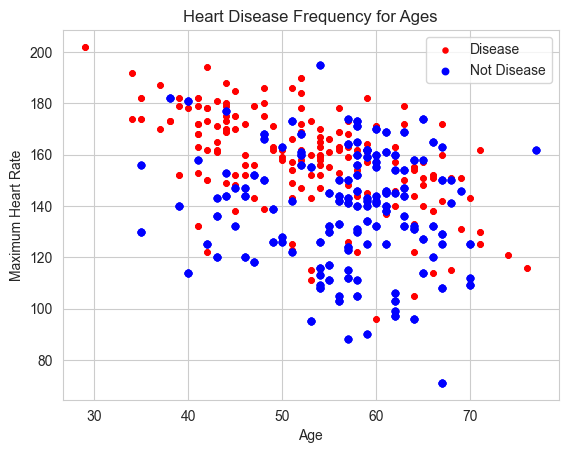

In [469]:
plot_data(data)

In [470]:
# Standardize the data.
X, y = standardize(data)

# Check that the data is normalized correctly
print("X means: ", np.mean(X) )
print("X stds: ", np.std(X) )

# Make a copy of y and change values from 0 to -1
y_copy = y.copy()
y_copy[y_copy == 0] = -1

# 20% from the data will be used for test
train_x, test_x, train_y, test_y = train_test_split(X, y_copy, test_size = 0.2)

#The accuracies of the models
accuracies={}

X means:  -7.3320544965864e-19
X stds:  1.0


# AdaBoost

In [471]:
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate
# Calling the model Adaboost that we created
clf = Adaboost(n_clf = 50)
clf.fit(train_x, train_y)
adaboost_prediction = clf.predict(test_x)
acc = accuracy_score(test_y, adaboost_prediction) * 100
print("Test Accuracy of Adaboost Algorithm: {:.2f}%".format(acc))
accuracies['Adaboost'] = acc


Test Accuracy of Adaboost Algorithm: 90.73%


# KNN

In [472]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10)  
knn.fit(train_x, train_y)
knn_prediction = knn.predict(test_x)
acc = knn.score(test_x, test_y) * 100
print("Test Score of KNN: {:.2f}%".format(acc))
accuracies['KNN'] = acc

Test Score of KNN: 86.34%


## Compare between Adaboost and KNN

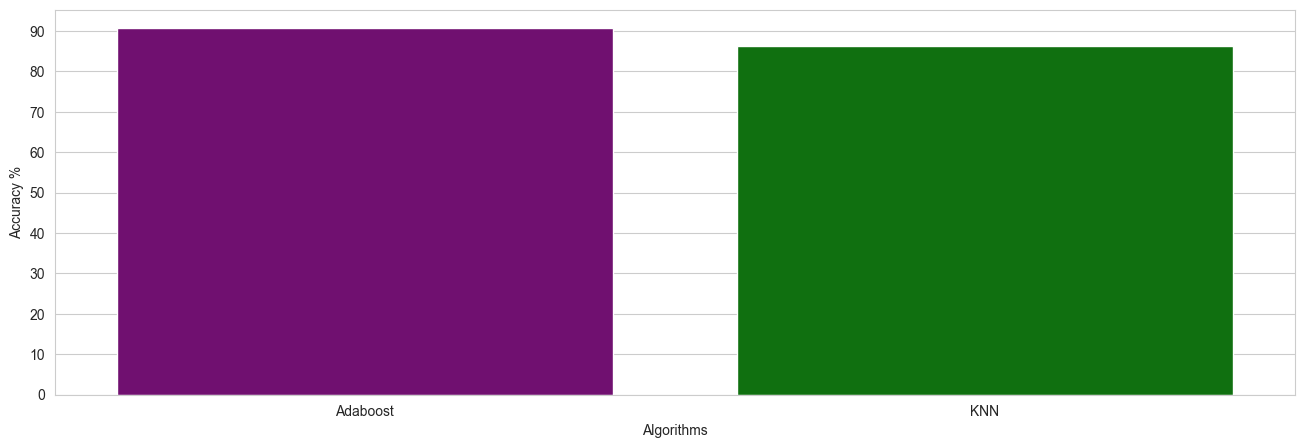

In [473]:
colors = ["purple", "green"]
sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

#### Compare the Algorithms with table:

In [474]:
# Calculate confusion matrixs for each
cm = confusion_matrix(test_y, adaboost_prediction)
cm1 = confusion_matrix(test_y, knn_prediction)

# Calculate True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
TN, FP, FN, TP = cm.ravel()

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP)
recall_adaboost = TP / (TP + FN)
f1_score_adaboost = 2 * (precision * recall_adaboost) / (precision + recall_adaboost)
fpr_adaboost = FP / (FP + TN)

TN, FP, FN, TP = cm1.ravel()

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP)
recall_knn = TP / (TP + FN)
f1_score_knn = 2 * (precision * recall_knn) / (precision + recall_knn)
fpr_knn = FP / (FP + TN)

# Compare with the table below
table = [['Algorithm', 'Accuracy','FPR', 'Recall', 'F1 Score'],
          ['Adaboost','{:.2f}%'.format(accuracies['Adaboost']), '{:.2f}%'.format(fpr_adaboost*100), '{:.2f}%'.format(recall_adaboost*100), '{:.2f}%'.format(f1_score_adaboost*100)],
          ['KNN', '{:.2f}%'.format(accuracies['KNN']), '{:.2f}%'.format(fpr_knn*100), '{:.2f}%'.format(recall_knn*100), '{:.2f}%'.format(f1_score_knn*100)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤════════════╤════════╤══════════╤════════════╕
│ Algorithm   │ Accuracy   │ FPR    │ Recall   │ F1 Score   │
╞═════════════╪════════════╪════════╪══════════╪════════════╡
│ Adaboost    │ 90.73%     │ 9.62%  │ 91.09%   │ 90.64%     │
├─────────────┼────────────┼────────┼──────────┼────────────┤
│ KNN         │ 86.34%     │ 12.50% │ 85.15%   │ 86.00%     │
╘═════════════╧════════════╧════════╧══════════╧════════════╛


#### The Confusion Matrixs


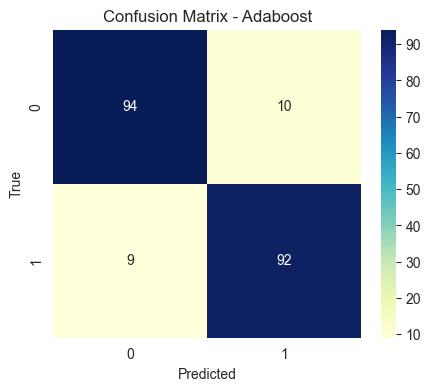

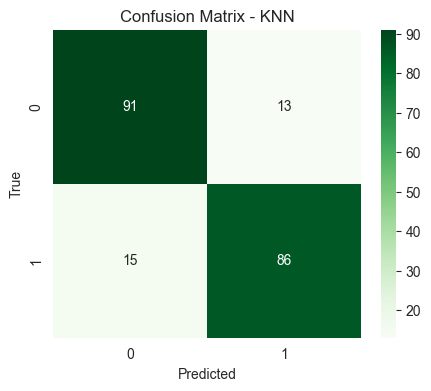

In [475]:
from sklearn.metrics import confusion_matrix

cm_adaboost = confusion_matrix(test_y,adaboost_prediction)
cm_knn = confusion_matrix(test_y,knn_prediction)


# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title, cmap):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=True, square=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot Adaboost confusion matrix with a customized color palette
plot_confusion_matrix(cm_adaboost, 'Confusion Matrix - Adaboost', 'YlGnBu')

# Plot KNN confusion matrix with the default 'Greens' color palette
plot_confusion_matrix(cm_knn, 'Confusion Matrix - KNN', 'Greens')



# Change parameters of the data

In [476]:
# Reading different data each time for testing 
data = load_data()
data_without_2_par = load_data_without_2_parameters()
data_without_6_par = load_data_without_6_parameters()
data_without_ = load_data_without_more_parameters()

In [477]:
# Standardize + Normalize the data.
X, y = standardize(data)
X1, y1 = standardize(data_without_2_par)
X2, y2 = standardize(data_without_6_par)
X3, y3 = standardize(data_without_)

# Make a copy of y and change values from 0 to -1
y_copy = y.copy()
y1_copy = y1.copy()
y2_copy = y2.copy()
y3_copy = y3.copy()
y_copy[y_copy == 0] = -1
y1_copy[y1_copy == 0] = -1
y2_copy[y2_copy == 0] = -1
y3_copy[y3_copy == 0] = -1

# 20% from the data will be used for test
train_x, test_x, train_y, test_y = train_test_split(X, y_copy, test_size = 0.2)
train_x1, test_x1, train_y1, test_y1 = train_test_split(X1, y1_copy, test_size = 0.2)
train_x2, test_x2, train_y2, test_y2 = train_test_split(X2, y2_copy, test_size = 0.2)
train_x3, test_x3, train_y3, test_y3 = train_test_split(X3, y3_copy, test_size = 0.2)

# Calling the model Adaboost that we created
clf = Adaboost(n_clf = 50)
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc = accuracy_score(test_y, y_pred) * 100
print("Test Accuracy of Adaboost Algorithm: {:.2f}%".format(acc))

clf = Adaboost(n_clf = 50)
clf.fit(train_x1, train_y1)
y_pred = clf.predict(test_x1)
acc1 = accuracy_score(test_y1, y_pred) * 100
print("Test Accuracy of Adaboost Algorithm without 2 columns: {:.2f}%".format(acc1))

clf = Adaboost(n_clf = 50)
clf.fit(train_x2, train_y2)
y_pred = clf.predict(test_x2)
acc2 = accuracy_score(test_y2, y_pred) * 100
print("Test Accuracy of Adaboost Algorithm without 6 columns: {:.2f}%".format(acc2))

clf = Adaboost(n_clf = 50)
clf.fit(train_x3, train_y3)
y_pred = clf.predict(test_x3)
acc3 = accuracy_score(test_y3, y_pred) * 100
print("Test Accuracy of Adaboost Algorithm without 6 plus columns: {:.2f}%".format(acc3))

Test Accuracy of Adaboost Algorithm: 86.83%
Test Accuracy of Adaboost Algorithm without 2 columns: 87.80%
Test Accuracy of Adaboost Algorithm without 6 columns: 80.49%
Test Accuracy of Adaboost Algorithm without 6 plus columns: 70.73%


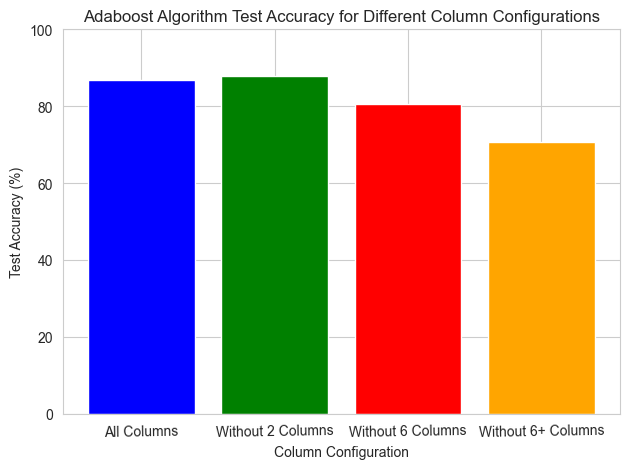

In [478]:
# List of column configurations
column_configurations = ['All Columns', 'Without 2 Columns', 'Without 6 Columns', 'Without 6+ Columns']

# List of test accuracies
test_accuracies = [acc, acc1, acc2, acc3]
# Define colors for each bar
colors = ['blue', 'green', 'red', 'orange']  

# Create a bar chart
plt.bar(column_configurations, test_accuracies, color=colors)
plt.xlabel('Column Configuration')
plt.ylabel('Test Accuracy (%)')
plt.title('Adaboost Algorithm Test Accuracy for Different Column Configurations')
plt.ylim(0, 100)  # Set the y-axis limits to show percentages from 0% to 100%
plt.xticks(rotation=1)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # To avoid label cutoff
plt.show()

### comparing between Adaboost with 50 stumps and 100 stumps

Test Accuracy of Adaboost Algorithm with 50 stumps: 90.73%
Test Accuracy of Adaboost Algorithm with 100 stumps: 90.73%


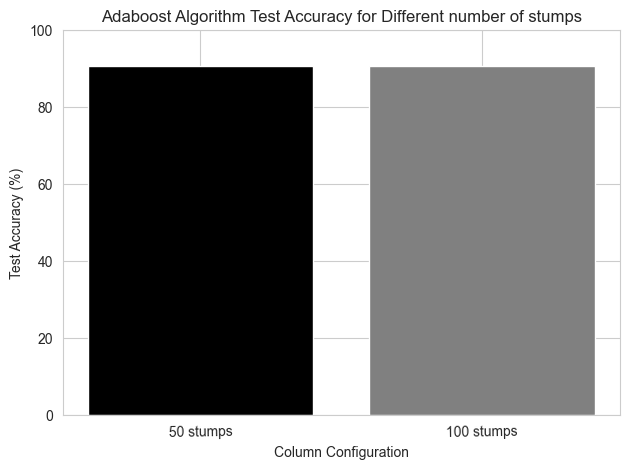

KeyboardInterrupt: 

In [479]:
accuracies_stumps={}
Adaboost_50 = accuracies['Adaboost']
print("Test Accuracy of Adaboost Algorithm with 50 stumps: {:.2f}%".format(Adaboost_50))


# Calling the model Adaboost that we created
clf = Adaboost(n_clf = 100)
clf.fit(train_x, train_y)
adaboost_prediction = clf.predict(test_x)
acc = accuracy_score(test_y, adaboost_prediction) * 100
print("Test Accuracy of Adaboost Algorithm with 100 stumps: {:.2f}%".format(acc))
accuracies_stumps['Adaboost_100'] = acc


test_accuracies1 = [Adaboost_50, acc]
# Define colors for each bar
colors1 = ['black', 'grey']
column_configurations1 = ['50 stumps', '100 stumps']  

# Create a bar chart
plt.bar(column_configurations1, test_accuracies1, color=colors1)
plt.xlabel('Column Configuration')
plt.ylabel('Test Accuracy (%)')
plt.title('Adaboost Algorithm Test Accuracy for Different number of stumps')
plt.ylim(0, 100)  # Set the y-axis limits to show percentages from 0% to 100%
plt.xticks(rotation=1)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # To avoid label cutoff
plt.show()



# Test for a new healthy patiant

In [ ]:
# Function to standardize features
def standardize_new(data):
    mean = np.mean(data)
    std = np.std(data)
    # Add a small epsilon value to the denominator to avoid division by zero
    epsilon = 1e-8
    standardized_data = (data - mean) / (std + epsilon)
    return standardized_data

# New example - replace the feature values below with the values of your new example
new_example_features = [61,0,0,145,307,0,0,146,1,1,1,0,3] # This is healthy person

# Convert the new example features into a 2D numpy array
new_example_features_array = np.array([new_example_features])

# Standardize the new example features using the same method used for the training data
X_new_standardized = standardize_new(new_example_features_array)


# Create an instance of the Adaboost class with the desired number of weak classifiers (50 in this case)
adaboost_model = Adaboost(n_clf=100)

# Train the AdaBoost model on your training data using the fit method
adaboost_model.fit(train_x, train_y)

# Make predictions for the new example using the trained AdaBoost model
predicted_target = adaboost_model.predict(X_new_standardized)

print("Predicted target for the new example is:", predicted_target[0], "\nso:")
# Print the predicted target for the new example
if predicted_target[0] == 1:
    print("Sick")
else:
    print("Not Sick")

Predicted target for the new example is: -1.0 
so:
Not Sick
